In [126]:
from string import punctuation, digits
import numpy as np
import matplotlib.pyplot as plt
import re
import pdb
import random
import pandas as pd

In [7]:
np.random.seed(0)

text_length_quantiles = 0
word_length_quantiles = 0

In [8]:
def read_data(filepath):
    """
    Returns an array of labels and an array of the corresponding texts
    """
    f = open(filepath, 'r')
    all_labels = []
    all_texts = []
    for line in f:
        label, text = line.split('\t')
        all_labels.append(int(label))
        all_texts.append(text)
    return (np.array(all_labels), all_texts)

def read_heldout_data(filepath):
    f = open(filepath, 'r')
    all_texts = []
    for text in f:
        all_texts.append(text)
    return all_texts

def save_submit(test_text, predictions):
    f = open('./submit.tsv','w')
    lines = []
    for i in range(len(test_text)):
        lines.append('{}\t{}'.format(int(predictions[i]), test_text[i]))
    f.writelines(lines)
    f.close()

In [9]:
def read_toy_data(filepath):
    """
    Returns (labels, data) for toy data
    """
    f = open(filepath, 'r')
    toy_labels = []
    toy_data = []
    for line in f:
        label, x, y = line.split('\t')
        toy_labels.append(int(label))
        toy_data.append([float(x), float(y)])
    return (np.array(toy_labels), np.array(toy_data))

def extract_words(input_string):
    """
      Returns a list of lowercase words in a string.
      Punctuation and digits are separated out into their own words.
    """
    for c in punctuation + digits:
        input_string = input_string.replace(c, ' ' + c + ' ')

    return input_string.lower().split()

def extract_dictionary(texts):
    """
      Given an array of texts, returns a dictionary of unigrams and bigrams.
      Each line is passed into extract_words, and a list on unique
      unigrams and bigrams is maintained.

      In addition, it computes quartiles of text length (in # of words) and word
      length (in # of characters).
    """
    global text_length_quantiles
    global word_length_quantiles
    unigrams = []
    bigrams  = []
    text_lengths = []
    word_lengths = []
    for text in texts:
        word_list = extract_words(text)
        text_lengths.append(len(word_list))
        for i, word in enumerate(word_list):
            word_lengths.append(len(word))
            if(word not in unigrams):
                unigrams.append(word)
            if(i > 0):
                bigram = previous_word + '_' + word
                if(bigram not in bigrams):
                    bigrams.append(bigram)
            previous_word = word
    dictionary = unigrams + bigrams
    text_length_quantiles = [np.percentile(text_lengths, k) for k in [25,50,75]]
    word_length_quantiles = [np.percentile(word_lengths, k) for k in [25,50,75]]
    return dictionary


def extract_feature_vectors(texts, dictionary):
    """
      Returns the feature representation of the data.
      The returned matrix is of shape (n, m), where n is the number of texts
      and m the total number of features (entries in the dictionary and any
      additional feature).
    """

    num_of_new_features = 5 # Number of features other than bag of words
    num_texts = len(texts)
    feature_matrix = np.zeros([num_texts, len(dictionary) + num_of_new_features])

    for i, text in enumerate(texts):
        #### Unigrams and bigrams
        word_list = extract_words(text)
        num_words = len(word_list)
        for j,word in enumerate(word_list):
            if(word in dictionary):
                feature_matrix[i, dictionary.index(word)] = 1
            if(j > 0):
                bigram = previous_word + '_' + word
                if(bigram in dictionary):
                    feature_matrix[i, dictionary.index(bigram)] = 1
            previous_word = word

        #### Additional Features
        # Binary features for text length
        feature_matrix[i, len(dictionary) + 0] = (num_words < text_length_quantiles[0]) # Bottom 25%
        feature_matrix[i, len(dictionary) + 1] = (num_words < text_length_quantiles[1]) # Bottom 50%
        feature_matrix[i, len(dictionary) + 2] = (num_words < text_length_quantiles[2]) # Bottom 75%
        lengths = [len(w) for w in word_list]
        feature_matrix[i, len(dictionary) + 3] = sum(lengths)/float(len(lengths)) # Average word length
        feature_matrix[i, len(dictionary) + 4] = len(set(word_list)) # Unique words

        """
        TODO: try more features
        Remember to change variable 'num_of_new_features'!
        """
        # Add your own features here

    return feature_matrix

def sigmoid(logit):
    return 1 / (1 + np.exp(-logit) )



In [81]:
def get_gradient(logit, label, x):
    '''
        Compute gradient of loss in respect to theta and theta_0.

        Hint: If your expression for the gradient involves dividing by
        a probability, it is likely numerically unstable. If you
        expand you expression for the gradient, your end expression
        should not include dividing by any probabalities.
    '''
    
    p = sigmoid(logit)
    theta_gradient = (p-label)*x
    theta_0_gradient = (p-label)
    
    # raise NotImplementedError("Implement your gradient function!")
    return theta_gradient, theta_0_gradient

def logistic_regression(feature_matrix, labels, theta, theta_0, T=5, l=0, eta=1e-3):
    """
        TODO: IMPLEMENT LOGISTIC REGRESSION WITH SGD
        Hint: You may want to implement a gradient function!
    """
    theta, theta_0 = np.copy(theta), np.copy(theta_0)
    nsamples = len(labels)
    
    lrate = eta
    
    for t in range(T):
        
        n = random.randrange(nsamples)
#         for n in range(nsamples):
        
        labeln = labels[n]
        xn = feature_matrix[n]
        logit = (theta@xn) + theta_0
        delta_theta, delta_theta_0 = get_gradient(logit, labeln, xn)
        
        delta_theta = delta_theta + l*theta

        theta = theta - lrate*delta_theta
        theta_0 = theta_0 - lrate*delta_theta_0
        
    # raise NotImplementedError("Implement your logistic_regression function!")

    return theta, theta_0

def classify(feature_matrix, theta_0, theta):
    """
      TODO: IMPLEMENT FUNCTION
      Classifies a set of data points given a weight vector and offset.
      Inputs are an (m, n) matrix of input vectors (m data points and n features),
      a real number offset, and a length n parameter vector.
      Returns a length m label vector. Note, for both Percetron and Logistic
      Regression, the prediction is 1 if (Theta X + Theta_0) > 0 and 0 otherwise.
      In the case of LR, the decision rule based on if sigmoid(Theta X + Theta_0) > .5,
      which is equivalent as Sigmoid of 0 is 0.5.
    """
    logit = (feature_matrix@theta) + theta_0
    sig = sigmoid(logit)
    predictions = np.where(sig<0.5, 0,1)
    #raise NotImplementedError("Implement your classify function!")
    return predictions

In [166]:
def score_accuracy(predictions, true_labels):
    """
    Inputs:
        - predictions: array of length (n,1) containing 1s and 0s
        - true_labels: array of length (n,1) containing 1s and 0s
    Output:
        - percentage of correctly predicted labels
    """
    correct = 0
    for i in range(len(true_labels)):
        if(predictions[i] == true_labels[i]):
            correct = correct + 1

    percentage_correct = 100.0 * correct / len(true_labels)
    print("Method gets " + str(percentage_correct) + "% correct (" + str(correct) + " out of " + str(len(true_labels)) + ").")
    return percentage_correct


def plot_2d_examples(feature_matrix, labels, theta_0, theta, title):
    """
      Uses Matplotlib to plot a set of labeled instances, and
      a decision boundary line.
      Inputs: an (m, 2) feature_matrix (m data points each with
      2 features), a length-m label vector, and hyper-plane
      parameters theta_0 and length-2 vector theta.
    """

    cols = []
    xs = []
    ys = []

    for i in range(len(labels)):
        if(labels[i] == 1):
            cols.append('b')
        else:
            cols.append('r')
        xs.append(feature_matrix[i][0])
        ys.append(feature_matrix[i][1])

    plt.scatter(xs, ys, s=40, c=cols)
    [xmin, xmax, ymin, ymax] = plt.axis()

    linex = []
    liney = []
    for x in np.linspace(xmin, xmax):
        linex.append(x)
        if(theta[1] != 0.0):
            y = (-theta_0 - theta[0]*x) / (theta[1])
            liney.append(y)
        else:
            liney.append(0)
    plt.suptitle(title, fontsize=15)
    plt.plot(linex, liney, 'k-')
    plt.show()


def plot_scores(parameter,parameter_values,train_scores,validation_scores,title):
    """
      Uses Matplotlib to plot scores as a function of hyperparameters.
      Inputs:
           - parameter:  string, one of 'Lambda' or 'Iterations'
           - parameter_values: a list n of parameter values
           - train_scores: a list of n scores on training data
           - validations:  a list of n scores on validation data
           - title: String
    """
    fig = plt.figure()
#     plt.plot(Tvals,scorelist)
    fig.suptitle(title)
#     plt.xlabel('T')
#     plt.ylabel('score in %')

    plt.plot(parameter_values, train_scores,'-o')
    plt.plot(parameter_values, validation_scores,'-o')
    plt.legend(['Training Set','Validation Set'], loc='upper right')
#     plt.title(title)
    plt.xscale('log')
    plt.xlabel('Hyperparameter: ' + parameter)
    plt.ylabel('Accuracy (%)')
    plt.show()



In [85]:
toy_labels, toy_data = read_toy_data('toy_data.tsv')

print("Project 1: Linear Models \n Part 1: \t Verifying your models with toy data ")
# Train classifiers
T =  5000 # Choose values
l = 0

num_samples, num_features = toy_data.shape
init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)

Project 1: Linear Models 
 Part 1: 	 Verifying your models with toy data 


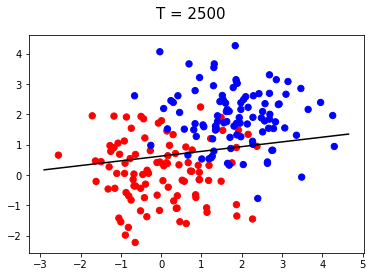

Method gets 74.5% correct (149 out of 200).
Score for T= 2500 is 74.5


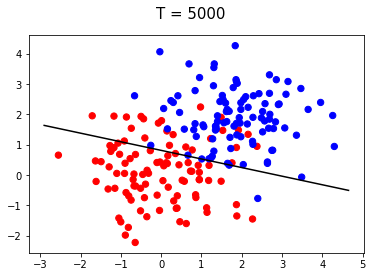

Method gets 87.0% correct (174 out of 200).
Score for T= 5000 is 87.0


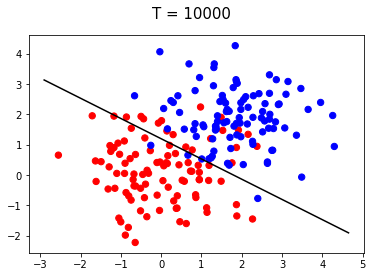

Method gets 89.5% correct (179 out of 200).
Score for T= 10000 is 89.5


In [94]:
# T =  5000 # Choose values
l = 0
eta = 1e-3

num_samples, num_features = toy_data.shape
init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)
T =  2500
theta, theta_0 = logistic_regression(toy_data, toy_labels, init_theta, init_theta_0, T=T)
plot_2d_examples(toy_data, toy_labels, theta_0, theta, 'T = {}'.format(T))
print('Score for T=',T, 'is',score_accuracy(classify(toy_data, theta_0, theta), toy_labels))
T =  5000
theta, theta_0 = logistic_regression(toy_data, toy_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)
plot_2d_examples(toy_data, toy_labels, theta_0, theta, 'T = {}'.format(T))
print('Score for T=',T, 'is',score_accuracy(classify(toy_data, theta_0, theta), toy_labels))
T =  10000
theta, theta_0 = logistic_regression(toy_data, toy_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)
plot_2d_examples(toy_data, toy_labels, theta_0, theta, 'T = {}'.format(T))
print('Score for T=',T, 'is',score_accuracy(classify(toy_data, theta_0, theta), toy_labels))



In [ ]:
print("Creating score list varying T")

In [113]:
Tvals = list(range(0,30000,1000))
scorelist = []

for t in Tvals:
    init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)
    theta, theta_0 = logistic_regression(toy_data, toy_labels, init_theta, init_theta_0, T=t)
    tscore = score_accuracy(classify(toy_data, theta_0, theta), toy_labels)
    scorelist.append(tscore)


Method gets 47.5% correct (95 out of 200).
Method gets 47.0% correct (94 out of 200).
Method gets 66.0% correct (132 out of 200).
Method gets 78.5% correct (157 out of 200).
Method gets 82.0% correct (164 out of 200).
Method gets 92.5% correct (185 out of 200).
Method gets 83.0% correct (166 out of 200).
Method gets 87.5% correct (175 out of 200).
Method gets 88.5% correct (177 out of 200).
Method gets 85.5% correct (171 out of 200).
Method gets 90.5% correct (181 out of 200).
Method gets 92.5% correct (185 out of 200).
Method gets 89.5% correct (179 out of 200).
Method gets 88.0% correct (176 out of 200).
Method gets 87.5% correct (175 out of 200).
Method gets 93.5% correct (187 out of 200).
Method gets 90.5% correct (181 out of 200).
Method gets 91.0% correct (182 out of 200).
Method gets 92.5% correct (185 out of 200).
Method gets 92.5% correct (185 out of 200).
Method gets 91.0% correct (182 out of 200).
Method gets 93.5% correct (187 out of 200).
Method gets 93.0% correct (186 out

Text(0,0.5,'score in %')

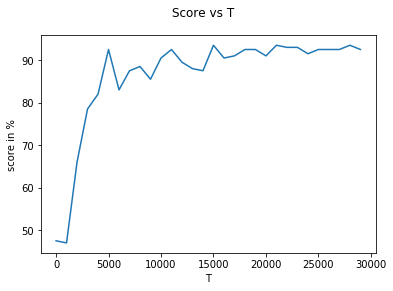

In [163]:
fig = plt.figure()
plt.plot(Tvals,scorelist)
fig.suptitle('Score vs T')
plt.xlabel('T')
plt.ylabel('score in %')

In [115]:
########## READ DATA ##########


'''
  Using the code p1.extract_feature_vectors, get a feature matrix
  for each text.
'''
print("Part 2.1: \t Load the data. Extract features")
#Training data
train_labels, train_text = read_data('train.tsv')
dictionary = extract_dictionary(train_text)

Part 2.1: 	 Load the data. Extract features


In [175]:
len(dictionary)

26816

In [197]:
with open('SAT_words.txt') as f:
    satwords = f.read().splitlines()

In [198]:
with open('Stopwords.txt') as g:
    stopwords = g.read().splitlines()

In [199]:
print(len(stopwords), len(satwords))

127 5014


In [202]:
masterdict = dictionary + stopwords + satwords
masterdict = list(set(masterdict))
print(len(masterdict))

31693


In [116]:
train_feature_matrix = extract_feature_vectors(train_text, dictionary)

print(train_feature_matrix.shape)

(1800, 26821)


In [117]:
# train_labels, train_text = read_data('train.tsv')
# dictionary = extract_dictionary(train_text)

#Validation data
val_labels, val_text = read_data('validation.tsv')
valdict = extract_dictionary(val_text)
val_feature_matrix = extract_feature_vectors(val_text, valdict)

print(val_feature_matrix.shape)

(350, 9546)


In [123]:
val_feature_matrix2 = extract_feature_vectors(val_text, dictionary)

print(val_feature_matrix2.shape)

(350, 26821)


In [118]:
print("Part 2.2: \t Run the baseline model")
T = 200000 # maximum number of updates
l =  0.01 # lambda
eta = 0.001
num_features = train_feature_matrix.shape[-1]
init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)

theta, theta_0 = logistic_regression(train_feature_matrix, train_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)

Part 2.2: 	 Run the baseline model


In [120]:
theta.shape, theta_0.shape

((26821,), (1,))

In [121]:
train_predictions = classify(train_feature_matrix, theta_0, theta)
train_score = score_accuracy(train_predictions, train_labels)
print("Train Score for Logsitic-Regression: {}".format(train_score))

Method gets 89.05555555555556% correct (1603 out of 1800).
Train Score for Logsitic-Regression: 89.05555555555556


In [124]:
val_predictions = classify(val_feature_matrix2, theta_0, theta)
val_score = score_accuracy(val_predictions, val_labels)
print("Validation Score for Logsitic-Regression: {}".format(val_score))


Method gets 83.71428571428571% correct (293 out of 350).
Validation Score for Logsitic-Regression: 83.71428571428571


In [131]:
print("Part 2.3: \t Try to find the best hyper-parameters!")
"""
TODO:
1) For multiple values of eta and lambda:
    - Predict labels for training set (using function 'classify')
    - Calculate training accuracy (using function 'score_accuracy')
    - Predict labels for validation set (using function 'classify')
    - Calculate validation accuracy (using function 'score_accuracy')
    - Plot your scores (using function 'plot_scores')
2) Choose optimal learning method and parameters based on validation accuracy

"""
etas =[0.0001, 0.001, .01, 1]
lambdas =[0.0001, 0.001, .01, 1]

scoredf = pd.DataFrame(index=list(range((len(etas))*(len(lambdas)))), columns = {'eta', 'lambda', 'training_score', 'validation_score'})


Part 2.3: 	 Try to find the best hyper-parameters!


In [ ]:
count = 0
for ee in etas:
    for ll in lambdas:
        T = 200000 # maximum number of updates
        l =  ll # lambda
        eta = ee
#         num_features = train_feature_matrix.shape[-1]
        init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)
        theta, theta_0 = logistic_regression(train_feature_matrix, train_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)
        
        train_predictions = classify(train_feature_matrix, theta_0, theta)
        train_score = score_accuracy(train_predictions, train_labels)
        val_predictions = classify(val_feature_matrix2, theta_0, theta)
        val_score = score_accuracy(val_predictions, val_labels)
        
        scoredf.loc[count,'eta'] = ee
        scoredf.loc[count,'lambda'] = ll
        scoredf.loc[count,'training_score'] = train_score
        scoredf.loc[count,'validation_score'] = val_score
        
        count+=1

Method gets 73.33333333333333% correct (1320 out of 1800).
Method gets 75.71428571428571% correct (265 out of 350).
Method gets 73.05555555555556% correct (1315 out of 1800).
Method gets 74.57142857142857% correct (261 out of 350).
Method gets 72.16666666666667% correct (1299 out of 1800).
Method gets 72.85714285714286% correct (255 out of 350).
Method gets 73.33333333333333% correct (1320 out of 1800).
Method gets 75.71428571428571% correct (265 out of 350).
Method gets 86.66666666666667% correct (1560 out of 1800).
Method gets 80.85714285714286% correct (283 out of 350).
Method gets 86.66666666666667% correct (1560 out of 1800).
Method gets 78.0% correct (273 out of 350).
Method gets 96.05555555555556% correct (1729 out of 1800).
Method gets 86.28571428571429% correct (302 out of 350).
Method gets 77.16666666666667% correct (1389 out of 1800).
Method gets 78.57142857142857% correct (275 out of 350).
Method gets 99.83333333333333% correct (1797 out of 1800).
Method gets 82.85714285714

In [138]:
from IPython.display import display, HTML

In [143]:
scoredf.sort_values(['validation_score'], ascending=False)

,validation_score,lambda,eta,training_score
6,86.2857,0.01,0.001,96.0556
9,86.2857,0.001,0.01,99.4444
10,83.7143,0.01,0.01,88.2222
8,82.8571,0.0001,0.01,99.8333
4,80.8571,0.0001,0.001,86.6667
7,78.5714,1,0.001,77.1667
12,78.2857,0.0001,1,81.3333
5,78,0.001,0.001,86.6667
14,77.4286,0.01,1,73.9444
11,76,1,0.01,73.3333


In [146]:
scoredf[scoredf['lambda']==0.001]

,validation_score,lambda,eta,training_score
1,74.5714,0.001,0.0001,73.0556
5,78,0.001,0.001,86.6667
9,86.2857,0.001,0.01,99.4444
13,50.8571,0.001,1,47.6667


In [ ]:
    """
      Uses Matplotlib to plot scores as a function of hyperparameters.
      Inputs:
           - parameter:  string, one of 'Lambda' or 'Iterations'
           - parameter_values: a list n of parameter values
           - train_scores: a list of n scores on training data
           - validations:  a list of n scores on validation data
           - title: String
    """

In [150]:
"".join(["Score vs eta for lambda = ", str(ll)])

'Score vs eta for lambda = 0.0001'

In [152]:
lambdas, ll

([0.0001, 0.001, 0.01, 1], 0.0001)

In [170]:
scoredf_lambda

,validation_score,lambda,eta,training_score
3,75.7143,1,0.0001,73.3333
7,78.5714,1,0.001,77.1667
11,76,1,0.01,73.3333
15,24.2857,1,1,26.6667


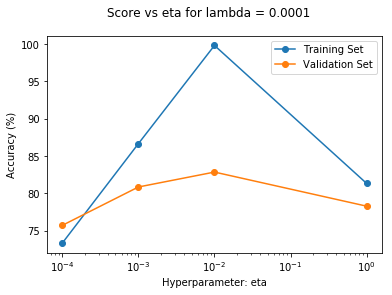

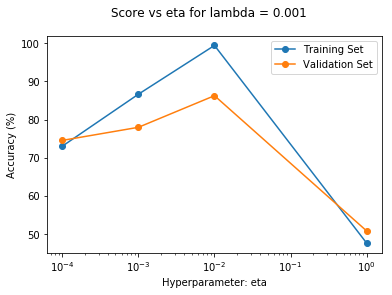

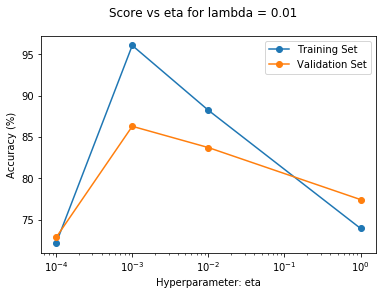

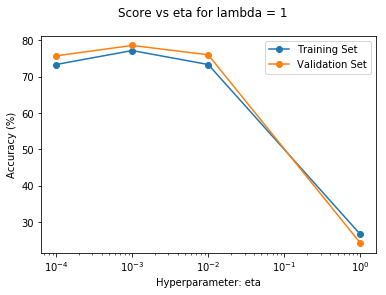

In [171]:
for ll in lambdas:
    scoredf_lambda = scoredf[scoredf['lambda']==ll]
    x_eta = scoredf_lambda['eta']
    val_eta = scoredf_lambda['validation_score']
    train_eta = scoredf_lambda['training_score']
    title = "".join(["Score vs eta for lambda = ", str(ll)])
    plot_scores('eta',x_eta,train_eta,val_eta, title=title)

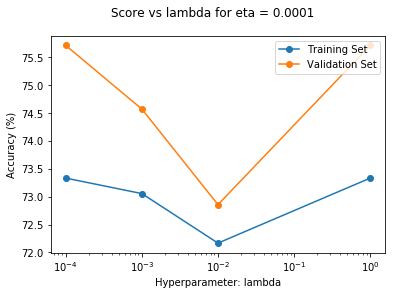

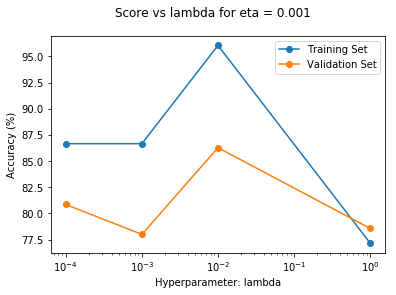

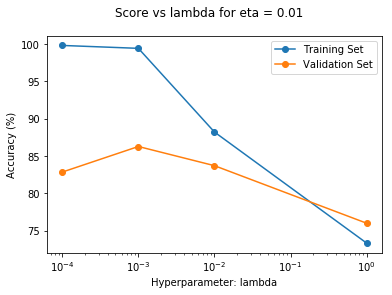

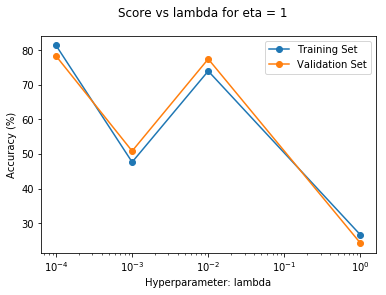

In [172]:
for ee in etas:
    scoredf_eta = scoredf[scoredf['eta']==ee]
    x_ll = scoredf_eta['lambda']
    val_ll = scoredf_eta['validation_score']
    train_ll = scoredf_eta['training_score']
    title = "".join(["Score vs lambda for eta = ", str(ee)])
    plot_scores('lambda',x_ll,train_ll,val_ll, title=title)

In [ ]:
plot_scores(parameter,parameter_values,train_scores,validation_scores,title)

In [207]:
print("Part 3: \t Exploring New Features \n Try modifying p1.extract_features to capture more sophisticated features and report your results in your report.\n")

Part 3: 	 Exploring New Features 
 Try modifying p1.extract_features to capture more sophisticated features and report your results in your report.



In [208]:
print("Sample case for part III")

train_labels, train_text = read_data('train.tsv')
dictionary = extract_dictionary(train_text)

train_feature_matrix_nd = extract_feature_vectors(train_text, masterdict)

print(train_feature_matrix_nd.shape)

#Validation data
val_labels, val_text = read_data('validation.tsv')

val_feature_matrix_nd = extract_feature_vectors(val_text, masterdict)

print(val_feature_matrix_nd.shape)

print("Part 2.2: \t Run the baseline model")
T = 200000 # maximum number of updates
l =  0.01 # lambda
eta = 0.001
num_features = train_feature_matrix_nd.shape[-1]
init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)

theta, theta_0 = logistic_regression(train_feature_matrix_nd, train_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)

train_predictions_nd = classify(train_feature_matrix_nd, theta_0, theta)
train_score = score_accuracy(train_predictions_nd, train_labels)
print("Train Score for Logsitic-Regression: {}".format(train_score))

val_predictions_nd = classify(val_feature_matrix_nd, theta_0, theta)
val_score = score_accuracy(val_predictions_nd, val_labels)
print("Validation Score for Logsitic-Regression: {}".format(val_score))

print("2.3 Passed!")


Sample case for part III
(1800, 31698)
(350, 31698)
Part 2.2: 	 Run the baseline model
Method gets 92.72222222222223% correct (1669 out of 1800).
Train Score for Logsitic-Regression: 92.72222222222223
Method gets 85.14285714285714% correct (298 out of 350).
Validation Score for Logsitic-Regression: 85.14285714285714
2.3 Passed!


In [ ]:
print('Create dataframe to try out different lambdas and etas for new dictionary')

train_feature_matrix_newdict = extract_feature_vectors(train_text, masterdict)
val_feature_matrix2_newdict = extract_feature_vectors(val_text, masterdict)

etas =[0.0001, 0.001, .01, 1]
lambdas =[0.0001, 0.001, .01, 1]

scoredf_newdict = pd.DataFrame(index=list(range((len(etas))*(len(lambdas)))), columns = {'eta', 'lambda', 'training_score', 'validation_score'})

count = 0
for ee in etas:
    for ll in lambdas:
        T = 200000 # maximum number of updates
        l =  ll # lambda
        eta = ee
        num_features = train_feature_matrix_newdict.shape[-1]
        init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)
        theta, theta_0 = logistic_regression(train_feature_matrix_newdict, train_labels, init_theta, init_theta_0, T=T, l=l, eta=eta)
        
        train_predictions_newdict = classify(train_feature_matrix_newdict, theta_0, theta)
        train_score_newdict = score_accuracy(train_predictions_newdict, train_labels)
        val_predictions_newdict = classify(val_feature_matrix2_newdict, theta_0, theta)
        val_score_newdict = score_accuracy(val_predictions_newdict, val_labels)
        
        scoredf_newdict.loc[count,'eta'] = ee
        scoredf_newdict.loc[count,'lambda'] = ll
        scoredf_newdict.loc[count,'training_score'] = train_score_newdict
        scoredf_newdict.loc[count,'validation_score'] = val_score_newdict
        
        count+=1



Create dataframe to try out different lambdas and etas for new dictionary
Method gets 72.0% correct (1296 out of 1800).
Method gets 72.85714285714286% correct (255 out of 350).
Method gets 70.83333333333333% correct (1275 out of 1800).
Method gets 70.57142857142857% correct (247 out of 350).
Method gets 75.16666666666667% correct (1353 out of 1800).
Method gets 72.57142857142857% correct (254 out of 350).
Method gets 73.33333333333333% correct (1320 out of 1800).
Method gets 75.71428571428571% correct (265 out of 350).
Method gets 90.72222222222223% correct (1633 out of 1800).
Method gets 84.0% correct (294 out of 350).
Method gets 91.16666666666667% correct (1641 out of 1800).
Method gets 80.28571428571429% correct (281 out of 350).
Method gets 96.38888888888889% correct (1735 out of 1800).
Method gets 87.14285714285714% correct (305 out of 350).
Method gets 75.38888888888889% correct (1357 out of 1800).
Method gets 76.57142857142857% correct (268 out of 350).
Method gets 99.888888888

In [212]:
scoredf_newdict

,validation_score,lambda,eta,training_score
0,72.8571,0.0001,0.0001,72
1,70.5714,0.001,0.0001,70.8333
2,72.5714,0.01,0.0001,75.1667
3,75.7143,1,0.0001,73.3333
4,84,0.0001,0.001,90.7222
5,80.2857,0.001,0.001,91.1667
6,87.1429,0.01,0.001,96.3889
7,76.5714,1,0.001,75.3889
8,83.4286,0.0001,0.01,99.8889
9,85.4286,0.001,0.01,99.2778


In [227]:

print("Part 4: \t Try your best hyper-parameters on the held-out test set!")
# ToDo: Choose optimal based on performance on validation set
T_optimal = 20000
lambda_optimal = 0.01
eta_optimal = 0.001

num_features = train_feature_matrix_newdict.shape[-1]
init_theta, init_theta_0 = np.random.randn(num_features), np.random.randn(1)
########## TESTING ##########
optimal_theta, optimal_theta_0 = logistic_regression(train_feature_matrix_newdict, train_labels, init_theta, init_theta_0, T=T_optimal, l=lambda_optimal, eta=eta_optimal)
test_text = read_heldout_data('test.tsv')
test_feature_matrix = extract_feature_vectors(test_text, masterdict)
predictions = classify(test_feature_matrix, optimal_theta_0, optimal_theta)



Part 4: 	 Try your best hyper-parameters on the held-out test set!


In [216]:
print("Part 4: \t Try your best hyper-parameters on the held-out test set!")
# ToDo: Choose optimal based on performance on validation set
T_optimal = 20000
lambda_optimal = 0.01
eta_optimal = 0.001

num_features_olddict = train_feature_matrix.shape[-1]
init_theta, init_theta_0 = np.random.randn(num_features_olddict), np.random.randn(1)
########## TESTING ##########
optimal_theta_olddict, optimal_theta_0_olddict = logistic_regression(train_feature_matrix, train_labels, init_theta, init_theta_0, T=T_optimal, l=lambda_optimal, eta=eta_optimal)
test_text = read_heldout_data('test.tsv')
test_feature_matrix_olddict = extract_feature_vectors(test_text, dictionary)
predictions_olddict = classify(test_feature_matrix_olddict, optimal_theta_0_olddict, optimal_theta_olddict)



Part 4: 	 Try your best hyper-parameters on the held-out test set!


In [253]:
print("Creating submit.tsv ...")
save_submit(test_text, predictions_olddict)


Creating submit.tsv ...
